In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
pd.options.display.max_rows = None

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
tr_data = pd.read_csv('/Users/yanathip_bang/Documents/Python projects/Hackathon LSEG/train.csv')
ts_data = pd.read_csv('/Users/yanathip_bang/Documents/Python projects/Hackathon LSEG/test.csv')

We will do comparison 3 classification models 
- K-nearnest neightbors 
- The Perceptron 
- SVM
- Decision tree

**Data Cleaning and understanding data** [Numurical data]

In [5]:
tr_data.info()
Prefix = []
for txt in tr_data['Name'].values:
    Prefix.append(txt.split(', ')[1].split(' ')[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
tr_data['Name'] = pd.DataFrame(Prefix)
tr_data['Name'].value_counts()
# We will clustering 2 groups into 
#1.ordinary people(od_ppl) 2.previlage people(pri_ppl)
mapping = {'Mr.':'od_ppl', 'Miss.':'od_ppl', 'Mrs.':'od_ppl', 
           'Master.':'pri_ppl', 'Dr.':'pri_ppl', 'Rev.':'pri_ppl',
          'Mlle.':'pri_ppl', 'Major.':'pri_ppl', 'Col.':'pri_ppl', 
          'the':'pri_ppl', 'Capt.':'pri_ppl', 'Ms.':'od_ppl', 'Sir.':'pri_ppl',
          'Lady.':'pri_ppl', 'Mme.':'pri_ppl', 'Don.':'pri_ppl', 'Jonkheer.':'pri_ppl'}
tr_data['Name'].replace(mapping, inplace=True)
prob_of_alive = tr_data[tr_data.iloc[:, 3] == 'od_ppl']['Survived'].sum()/len(tr_data[tr_data.iloc[:, 3] == 'od_ppl']['Survived'])*100
print('Probability to alive is ', prob_of_alive)
# Privilage people has probability to alive more than ordinary people, 50% over 37%
# We shall use One-hot encoding later to tackle this catagorical data

Probability to alive is  37.333333333333336


In [7]:
# From SibSp and Parch we can compute size of particular family
# Define family_size 
# 1 --> alone
# <5 --> small 
# <8 --> medium
# >8 --> large
tr_data['fam_size'] = tr_data['SibSp'].values + tr_data['Parch'].values + 1
dummy_txt = []
for num in tr_data['fam_size'].values:
    if num == 1:
        dummy_txt.append('alone')
    elif num < 5:
        dummy_txt.append('S')
    elif num < 8:
        dummy_txt.append('M')
    else:
        dummy_txt.append('L')
# Explore probability to alive of these groups
# Alone --> Alive 30%
# S --> Alive 57.87%
# M --> Alive 20.4%
# L --> Alive 0%
# We shall use One-hot encoding technique to dealing with this value
tr_data['fam_size'] = pd.DataFrame(dummy_txt)
prob_of_alive = tr_data[tr_data.iloc[:, 12] == 'L']['Survived'].sum()/len(tr_data[tr_data.iloc[:, 12] == 'L']['Survived'])*100
print('Probability to alive is ', prob_of_alive)
# Dropping old columns ['SibSp', 'Parch']
tr_data = tr_data.drop(columns=['SibSp', 'Parch'], axis=1)

Probability to alive is  0.0


In [8]:
# Explore and clean ticket column
ticket_list = []
for d in tr_data['Ticket'].values:
    if d.split(' ')[0] not in ticket_list:
        ticket_list.append(d.split(' ')[0])
# I think it's to hard to find pattern, I will drop this column
tr_data = tr_data.drop('Ticket', axis=1)

In [9]:
# Explore and clean cabin column --> too much nan values
tr_data = tr_data.drop(['Cabin'], axis=1)

<Axes: ylabel='Fare'>

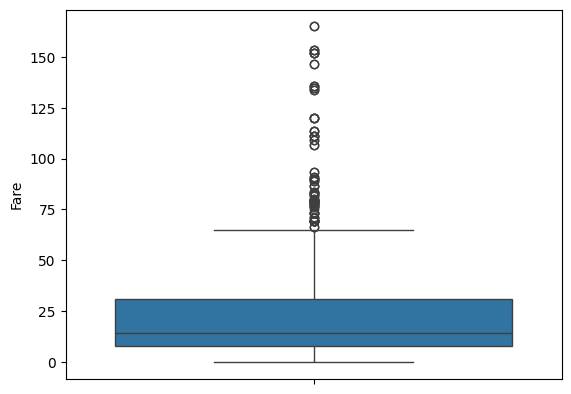

In [10]:
# Dealing with outliers using box plot technique
# We filter data in range (-3,3) SD 
tr_data['Fare'] = np.where((tr_data['Fare'] - tr_data['Fare'].mean()).abs() > 3 * tr_data['Fare'].std(), tr_data['Fare'].mean(), tr_data['Fare'])
sns.boxplot(tr_data['Fare'])

Text(0.5, 1.0, 'Mean :29.69911764705882 SD:13.002015226002882')

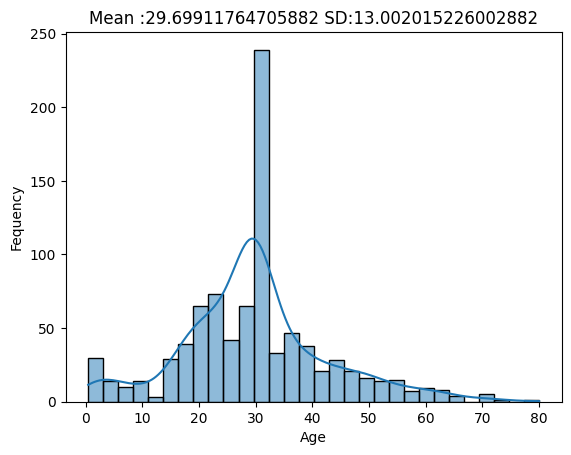

In [11]:
# Pclass 1<3<2 %Survived 27.7% < 17.72% < 24.23%
tr_data[tr_data.iloc[:, 2] == 3]['Survived'].sum()/len(tr_data[tr_data.iloc[:, 2] == 3]['Survived'])*100
tr_data['Age'].fillna(tr_data['Age'].mean(), inplace=True)
sns.histplot(tr_data['Age'], kde=True, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Fequency')
plt.title('Mean :'+ tr_data['Age'].mean().astype(str) + ' SD:' + tr_data['Age'].std().astype(str))
#Dealing nan value with mean() versus mode() --> Same distribution

**Check correlation between numirical columns**

Text(0.5, 1.0, 'Corr heatmap for each columns')

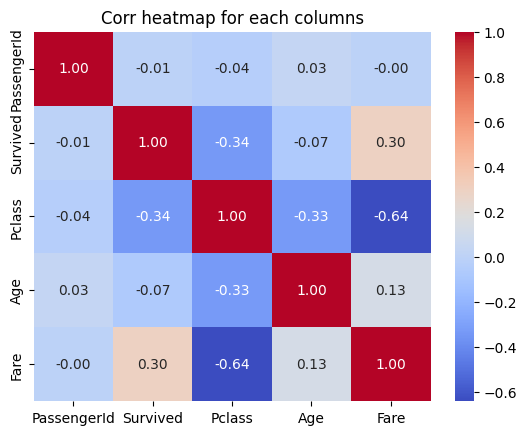

In [12]:
tr_data_num = tr_data.drop(columns = ['Sex', 'Embarked', 'Name', 'fam_size'])
corr_mat = tr_data_num.corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corr heatmap for each columns')
#Fare has mild corr with survived 

**Dealing with object value**

In [13]:
#Dealing with nan value in Cabin columns
#Hot-end labeling
#sns.histplot(tr_data['Embarked'])
tr_data['Embarked'].fillna(tr_data['Embarked'].mode()[0], inplace=True)
#tr_data['Cabin'].fillna(tr_data['Cabin'].mode()[0], inplace=True)
tr_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,fam_size
0,1,0,3,od_ppl,male,22.0,7.2500,S,S
1,2,1,1,od_ppl,female,38.0,71.2833,C,S
2,3,1,3,od_ppl,female,26.0,7.9250,S,alone
3,4,1,1,od_ppl,female,35.0,53.1000,S,S
4,5,0,3,od_ppl,male,35.0,8.0500,S,alone


In [14]:
#Dealing with 'Sex' and 'Embarked' with One-Hot encoding 
tr_data['Sex'] = tr_data['Sex'].replace({'male':0, 'female':1})
tr_data_encoding1 = pd.get_dummies(tr_data['Embarked'], prefix='Embarked')
tr_data_encoding2 = pd.get_dummies(tr_data['fam_size'], prefix='Famsize')
tr_data_encoding3 = pd.get_dummies(tr_data['Name'])
tr_data = pd.concat([tr_data, tr_data_encoding1, tr_data_encoding2, tr_data_encoding3], axis=1)
tr_data = tr_data.drop(columns = ['Embarked', 'fam_size', 'Name'], axis=1)
tr_data = tr_data.replace({True:0, False:1})

Modeling 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import accuracy_score

In [16]:
tr_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Famsize_L,Famsize_M,Famsize_S,Famsize_alone,od_ppl,pri_ppl
0,1,0,3,0,22.0,7.2500,1,1,0,1,1,0,1,0,1
1,2,1,1,1,38.0,71.2833,0,1,1,1,1,0,1,0,1
2,3,1,3,1,26.0,7.9250,1,1,0,1,1,1,0,0,1
3,4,1,1,1,35.0,53.1000,1,1,0,1,1,0,1,0,1
4,5,0,3,0,35.0,8.0500,1,1,0,1,1,1,0,0,1


In [17]:
X = tr_data[['Pclass', 'Sex', 'Age', 
            'Fare','Embarked_C', 'Embarked_Q', 'Embarked_S', 'Famsize_L',
            'Famsize_M', 'Famsize_S', 'Famsize_alone', 'od_ppl', 'pri_ppl']]
y = tr_data['Survived']
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
#Last bit - encode labels
robust_scaler = RobustScaler()
X_scaled_train = robust_scaler.fit_transform(X_train)
X_scaled_test = robust_scaler.fit_transform(X_test)

**Random Forest**

In [29]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_scaled_train, y_train)

y_pred_rf = rf_classifier.predict(X_scaled_test)

print(accuracy_score(y_test, y_pred_rf))

0.8044692737430168


**K-nearest neightbors**

In [30]:
KN = KNeighborsClassifier(n_neighbors=3)

KN.fit(X_scaled_train, y_train)

y_pred_kn = KN.predict(X_scaled_test)  
print(accuracy_score(y_test, y_pred_kn))

0.7932960893854749


**Supported Vector Machines**

In [32]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_classifier.fit(X_scaled_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_scaled_test)

# Evaluate the model
print(accuracy_score(y_test, y_pred_svm))

0.8044692737430168


**Perceptron**

In [33]:
perceptron_model = Perceptron(max_iter=1000, random_state=42)

# Train the model
perceptron_model.fit(X_scaled_train, y_train)

# Make predictions on the test set
y_pred = perceptron_model.predict(X_scaled_test)

# Evaluate the model
print(accuracy_score(y_test, y_pred))

0.7318435754189944


In [36]:
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg_model.fit(X_scaled_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_scaled_test)

print(accuracy_score(y_test, y_pred))

0.8100558659217877


In [23]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We choose RandomForest over others classifiers with n_estimators = 100
Accuracy = 79.98%

In [24]:
#Cleaning test data
Prefix = []
for txt in ts_data['Name'].values:
    Prefix.append(txt.split(', ')[1].split(' ')[0])
ts_data['Name'] = pd.DataFrame(Prefix)
ts_data['Name'].value_counts()
# We will clustering 2 groups into 
#1.ordinary people(od_ppl) 2.previlage people(pri_ppl)
mapping = {'Mr.':'od_ppl', 'Miss.':'od_ppl', 'Mrs.':'od_ppl', 
           'Master.':'pri_ppl', 'Dr.':'pri_ppl', 'Rev.':'pri_ppl',
          'Mlle.':'pri_ppl', 'Major.':'pri_ppl', 'Col.':'pri_ppl', 
          'the':'pri_ppl', 'Capt.':'pri_ppl', 'Ms.':'od_ppl', 'Sir.':'pri_ppl',
          'Lady.':'pri_ppl', 'Mme.':'pri_ppl', 'Dona.':'pri_ppl', 'Jonkheer.':'pri_ppl'}
ts_data['Name'].replace(mapping, inplace=True)

In [25]:
ts_data['fam_size'] = ts_data['SibSp'].values + ts_data['Parch'].values + 1
dummy_txt = []
for num in ts_data['fam_size'].values:
    if num == 1:
        dummy_txt.append('alone')
    elif num < 5:
        dummy_txt.append('S')
    elif num < 8:
        dummy_txt.append('M')
    else:
        dummy_txt.append('L')
ts_data['fam_size'] = pd.DataFrame(dummy_txt)
ts_data = ts_data.drop('Ticket', axis=1)
ts_data = ts_data.drop(['Cabin'], axis=1)

In [26]:
#Dealing with 'Sex' and 'Embarked' with One-Hot encoding 
ts_data['Sex'] = ts_data['Sex'].replace({'male':0, 'female':1})
ts_data_encoding1 = pd.get_dummies(ts_data['Embarked'], prefix='Embarked')
ts_data_encoding2 = pd.get_dummies(ts_data['fam_size'], prefix='Famsize')
ts_data_encoding3 = pd.get_dummies(ts_data['Name'])
ts_data = pd.concat([ts_data, ts_data_encoding1, ts_data_encoding2, ts_data_encoding3], axis=1)
ts_data = ts_data.replace({True:0, False:1})

In [27]:
ts_data['Age'].fillna(ts_data['Age'].mean(), inplace=True)
ts_data['Fare'].fillna(ts_data['Fare'].mean(), inplace=True)
ts_data.drop(columns=['Name', 'SibSp', 'Parch', 'Embarked', 'fam_size'], inplace=True)

In [39]:
#Submission part
X_submission = ts_data[['Pclass', 'Sex', 'Age', 'Famsize_L', 'Famsize_M',
            'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Famsize_S', 
                       'Famsize_alone', 'od_ppl', 'pri_ppl']]
X_submission_scaled = robust_scaler.fit_transform(X_submission)
y_submission = logreg_model.predict(X_submission_scaled)
submission = ts_data[['PassengerId']]
submission['Survived'] = y_submission
submission.to_csv("Titanic_logisticReg_ver1.csv", index=False)
submission

/var/folders/_8/nfxlv1x95rjczcpg_hvb1lbm0000gn/T/ipykernel_34307/3690548245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Survived'] = y_submission


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
